In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
!pip install config
!pip install jsonlines
import numpy as np
import json
import os
import pickle
import re
import h5py
import jsonlines
import nltk
import config
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

from collections import defaultdict
from typing import Any, Iterable, Mapping, MutableSequence, Optional, Sequence, Tuple
from sklearn.model_selection import StratifiedKFold



In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class Config:
    def __init__(self):
        # Paths for datasets and feature files
        self.data_path = '/content/drive/MyDrive/project/MUStARD-master/MUStARD-master/data/sarcasm_data.json'
        self.audio_features_path = '/content/drive/MyDrive/project/MUStARD-master/MUStARD-master/data/audio_features.p'
        self.utterance_video_features_path = '/content/drive/MyDrive/project/MUStARD-master/MUStARD-master/data/features/utterances_final/resnet_pool5.hdf5'
        self.context_video_features_path = '/content/drive/MyDrive/project/MUStARD-master/MUStARD-master/data/features/context_final/resnet_pool5 (2).hdf5'
        self.text_embeddings_path = '/content/drive/MyDrive/project/MUStARD-master/MUStARD-master/BERT_text_features/bert-output.jsonl'
        self.context_embeddings_path = '/content/drive/MyDrive/project/MUStARD-master/MUStARD-master/BERT_text_features/bert-output-context.jsonl'
        self.batch_size = 32
        self.num_epochs = 10

        # Additional configuration
        self.max_audio_frames = 300
        self.fixed_audio_features = 12
        self.max_video_frames = 96
        self.video_feature_dim = 2048
        self.text_embedding_dim = 768


class MultimodalDataLoader:
    def __init__(self, config):
        self.config = config
        self.data_input = []
        self.data_output = []
        self.load_data()

    def load_data(self):
        """
        Load and preprocess the dataset (text, audio, video).
        """
        print("Loading data...")
        # Load the text data (utterances, context)
        with open(self.config.data_path) as file:
            dataset_dict = json.load(file)
        print("Dataset loaded with", len(dataset_dict), "entries.")

        # Load BERT embeddings for text
        text_bert_embeddings = self.load_bert_embeddings(self.config.text_embeddings_path)
        context_bert_embeddings = self.load_bert_embeddings(self.config.context_embeddings_path)

        # Load audio features (pickled data)
        audio_features = self.load_audio_features(self.config.audio_features_path)

        # Load video features for utterances and context (HDF5)
        utterance_video_features = self.load_video_features(self.config.utterance_video_features_path)
        context_video_features = self.load_video_features(self.config.context_video_features_path)

        # Prepare data
        self.parse_data(
            dataset_dict,
            audio_features,
            utterance_video_features,
            context_video_features,
            text_bert_embeddings,
            context_bert_embeddings,
        )

    def load_bert_embeddings(self, path):
        """
        Load BERT embeddings for text or context.
        """
        embeddings = []
        print("Loading BERT embeddings from:", path)
        with jsonlines.open(path) as file:
            for entry in file:
                embeddings.append(np.array(entry['features'][0]['layers'][0]['values']))
        print("Loaded", len(embeddings), "BERT embeddings.")
        return embeddings

    def load_audio_features(self, path):
        """
        Load audio features from a pickle file.
        """
        print("Loading audio features from:", path)
        with open(path, 'rb') as file:
            return pickle.load(file, encoding='latin1')

    def load_video_features(self, path):
        """
        Load video features from an HDF5 file.
        """
        print("Loading video features from:", path)
        with h5py.File(path, 'r') as file:
            return {key: file[key][:] for key in file}

    def parse_data(self, dataset_dict, audio_features, utterance_video_features, context_video_features, text_embeddings, context_embeddings):
        """
        Prepare the dataset into an appropriate format for attention-based models.
        """
        print("Parsing data...")
        def fix_audio_features(audio, fixed_features=12, max_frames=300):
            if audio is None:
                return np.zeros((max_frames, fixed_features))
            fixed_audio = np.zeros((max_frames, fixed_features))
            num_frames = min(audio.shape[0], max_frames)
            features_to_copy = min(audio.shape[1], fixed_features)
            fixed_audio[:num_frames, :features_to_copy] = audio[:num_frames, :features_to_copy]
            return fixed_audio

        def fix_video_features(video, max_frames=96, feature_dim=2048):
            if video is None:
                return np.zeros((max_frames, feature_dim))
            fixed_video = np.zeros((max_frames, feature_dim))
            num_frames = min(video.shape[0], max_frames)
            fixed_video[:num_frames] = video[:num_frames]
            return fixed_video

        def fix_text_embedding(embedding, embedding_dim=768):
            if embedding is None or len(embedding) != embedding_dim:
                return np.zeros(embedding_dim)
            return embedding

        for idx, id_ in enumerate(dataset_dict):
            self.data_input.append({
                "utterance": dataset_dict[id_].get("utterance", ""),
                "context": dataset_dict[id_].get("context", []),
                "audio": fix_audio_features(audio_features.get(id_)),
                "utterance_video": fix_video_features(utterance_video_features.get(id_)),
                "context_video": fix_video_features(context_video_features.get(id_)),
                "text_embedding": fix_text_embedding(text_embeddings[idx]),
                "context_embedding": fix_text_embedding(context_embeddings[idx]),
            })
            self.data_output.append(dataset_dict[id_].get("sarcasm", 0))
        print("Data parsing complete. Total samples:", len(self.data_input))




In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, data_input, data_output):
        self.data_input = data_input
        self.data_output = data_output

    def __len__(self):
        return len(self.data_output)

    def __getitem__(self, idx):
        return self.data_input[idx], self.data_output[idx]


def multimodal_collate_fn(batch):
    features, labels = zip(*batch)

    # Text features (shape: [batch_size, text_dim])
    text = torch.tensor([f["text_embedding"] for f in features], dtype=torch.float32)

    # Context features (shape: [batch_size, context_dim])
    context = torch.tensor([f["context_embedding"] for f in features], dtype=torch.float32)

    # Audio features (mean pooling along frames)
    audio = pad_sequence([torch.tensor(f["audio"], dtype=torch.float32) for f in features], batch_first=True)
    audio = audio.mean(dim=1)  # Mean pooling reduces shape to (batch_size, features_per_frame)

    # Utterance video features (mean pooling along frames)
    utterance_video = pad_sequence([torch.tensor(f["utterance_video"], dtype=torch.float32) for f in features], batch_first=True)

    # Context video features (mean pooling along frames)
    context_video = pad_sequence([torch.tensor(f["context_video"], dtype=torch.float32) for f in features], batch_first=True)
    context_video = context_video.mean(dim=1)  # Mean pooling reduces shape to (batch_size, features_per_frame)

    # Labels (shape: [batch_size])
    labels = torch.tensor(labels, dtype=torch.long)

    print(f"text shape: {text.shape}")
    print(f"context shape: {context.shape}")
    print(f"audio shape: {audio.shape}")
    print(f"utterance_video shape: {utterance_video.mean(dim=1).shape}")
    print(f"context_video shape: {context_video.shape}")
    print(f"labels shape: {labels.shape}")

    return {
        "text": text,  # Shape: (batch_size, text_dim)
        "context": context,  # Shape: (batch_size, context_dim)
        "audio": audio,  # Shape: (batch_size, features_per_frame)
        "utterance_video": utterance_video.mean(dim=1),  # Shape: (batch_size, features_per_frame)
        "context_video": context_video,  # Shape: (batch_size, features_per_frame)
    }, labels


In [ ]:
config = Config()
data_loader = MultimodalDataLoader(config)


Loading data...
Dataset loaded with 690 entries.
Loading BERT embeddings from: /content/drive/MyDrive/project/MUStARD-master/MUStARD-master/BERT_text_features/bert-output.jsonl
Loaded 690 BERT embeddings.
Loading BERT embeddings from: /content/drive/MyDrive/project/MUStARD-master/MUStARD-master/BERT_text_features/bert-output-context.jsonl
Loaded 2261 BERT embeddings.
Loading audio features from: /content/drive/MyDrive/project/MUStARD-master/MUStARD-master/data/audio_features.p
Loading video features from: /content/drive/MyDrive/project/MUStARD-master/MUStARD-master/data/features/utterances_final/resnet_pool5.hdf5
Loading video features from: /content/drive/MyDrive/project/MUStARD-master/MUStARD-master/data/features/context_final/resnet_pool5 (2).hdf5
Parsing data...
Data parsing complete. Total samples: 690


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 1. Define Attention Mechanism (to focus on important parts of input features)
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn_weights = nn.Linear(hidden_dim, 1, bias=False)


    def forward(self, inputs):  # inputs: (batch_size, seq_len, hidden_dim)
        scores = self.attn_weights(inputs)  # (batch_size, seq_len, 1)
        attn_weights = F.softmax(scores, dim=1)  # Normalize attention scores
        context = torch.sum(inputs * attn_weights, dim=1)  # Weighted sum
        return context, attn_weights

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultimodalSarcasmModel(nn.Module):
    def __init__(self, text_dim, context_dim, audio_dim, video_dim, hidden_dim, output_dim):
        super(MultimodalSarcasmModel, self).__init__()
        # Fully connected layers for each modality
        self.text_fc = nn.Linear(text_dim, hidden_dim)
        self.context_fc = nn.Linear(context_dim, hidden_dim)
        self.audio_fc = nn.Linear(audio_dim, hidden_dim)
        self.video_fc = nn.Linear(video_dim, hidden_dim)
        self.attention = Attention(hidden_dim)

        self.dropout = nn.Dropout(p=0.5)

        # Combined layer
        combined_dim = hidden_dim * 5
        self.final_fc = nn.Linear(combined_dim, output_dim)

    def forward(self, text, context, audio, utterance_video, context_video):
        # Debugging input shapes
        print(f"Original text shape: {text.shape}")
        print(f"Original context shape: {context.shape}")
        print(f"Original audio shape: {audio.shape}")
        print(f"Original utterance_video shape: {utterance_video.shape}")
        print(f"Original context_video shape: {context_video.shape}")

        # Process text and context (no reshape needed)
        text_out = F.relu(self.text_fc(text))  # Shape: [batch_size, hidden_dim]
        context_out = F.relu(self.context_fc(context))  # Shape: [batch_size, hidden_dim]

        # Reshape audio if needed for multiplication
        if len(audio.shape) > 2:  # Example: audio shape is [batch_size, seq_len, feature_dim]
            audio = torch.mean(audio, dim=1)  # Apply mean pooling along seq_len
        print(f"Reshaped audio shape: {audio.shape}")
        audio_out = F.relu(self.audio_fc(audio))  # Shape: [batch_size, hidden_dim]

        # Reshape video features if needed
        if len(utterance_video.shape) > 2:  # Example: utterance_video shape is [batch_size, seq_len, feature_dim]
            utterance_video = utterance_video.mean(dim=1)  # Apply mean pooling along seq_len
        print(f"Reshaped utterance_video shape: {utterance_video.shape}")
        utterance_video_out = F.relu(self.video_fc(utterance_video))  # Shape: [batch_size, hidden_dim]

        if len(context_video.shape) > 2:  # Example: context_video shape is [batch_size, seq_len, feature_dim]
            context_video = context_video.mean(dim=1)  # Apply mean pooling along seq_len
        print(f"Reshaped context_video shape: {context_video.shape}")
        context_video_out = F.relu(self.video_fc(context_video))  # Shape: [batch_size, hidden_dim]

        # Concatenate features
        combined = torch.cat([text_out, context_out, audio_out, utterance_video_out, context_video_out], dim=-1)
        print(f"Combined feature shape: {combined.shape}")  # Should match [batch_size, hidden_dim * 5]

        # Final output
        output = self.final_fc(combined)
        return output


In [ ]:
# Example tensors
batch_size = 32
text_tensor = torch.randn(batch_size, 768)  # Shape: [batch_size, text_dim]
context_tensor = torch.randn(batch_size, 768)  # Shape: [batch_size, context_dim]
audio_tensor = torch.randn(batch_size, 300, 12)  # Shape: [batch_size, seq_len, audio_dim]
utterance_video_tensor = torch.randn(batch_size, 96, 2048)  # Shape: [batch_size, seq_len, video_dim]
context_video_tensor = torch.randn(batch_size, 96, 2048)  # Shape: [batch_size, seq_len, video_dim]


In [ ]:
text_tensor = text_tensor.to(device)
context_tensor = context_tensor.to(device)
audio_tensor = audio_tensor.to(device)
utterance_video_tensor = utterance_video_tensor.to(device)
context_video_tensor = context_video_tensor.to(device)

In [ ]:
# Initialize and test the model
model = MultimodalSarcasmModel(
    text_dim=768,
    context_dim=768,
    audio_dim=12,
    video_dim=2048,
    hidden_dim=512,
    output_dim=2
)
model.to(device)


MultimodalSarcasmModel(
  (text_fc): Linear(in_features=768, out_features=512, bias=True)
  (context_fc): Linear(in_features=768, out_features=512, bias=True)
  (audio_fc): Linear(in_features=12, out_features=512, bias=True)
  (video_fc): Linear(in_features=2048, out_features=512, bias=True)
  (attention): Attention(
    (attn_weights): Linear(in_features=512, out_features=1, bias=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (final_fc): Linear(in_features=2560, out_features=2, bias=True)
)

In [ ]:
# Forward pass
outputs = model(text_tensor, context_tensor, audio_tensor, utterance_video_tensor, context_video_tensor)


Original text shape: torch.Size([32, 768])
Original context shape: torch.Size([32, 768])
Original audio shape: torch.Size([32, 300, 12])
Original utterance_video shape: torch.Size([32, 96, 2048])
Original context_video shape: torch.Size([32, 96, 2048])
Reshaped audio shape: torch.Size([32, 12])
Reshaped utterance_video shape: torch.Size([32, 2048])
Reshaped context_video shape: torch.Size([32, 2048])
Combined feature shape: torch.Size([32, 2560])


In [ ]:
# Output debugging
print(f"Output shape: {outputs.shape}")  # Should be [batch_size, output_dim]

Output shape: torch.Size([32, 2])


In [ ]:
# Initialize the dataset
dataset = MultimodalDataset(data_loader.data_input, data_loader.data_output)

In [ ]:
from torch.utils.data import DataLoader, Subset

# Assuming `data_loader.data_input` and `data_loader.data_output` are already loaded
train_size = int(0.8 * len(data_loader.data_input))  # 80% training data
val_size = len(data_loader.data_input) - train_size  # 20% validation data
indices = list(range(len(data_loader.data_input)))

train_indices = indices[:train_size]
val_indices = indices[train_size:]

# # Create datasets for train and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=multimodal_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=multimodal_collate_fn)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

features, labels = next(iter(train_loader))

# Assuming labels are a PyTorch tensor
labels_numpy = labels.cpu().numpy()  # Convert to NumPy array if it's a tensor


# Define the weighted loss function and optimizer
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels_numpy)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Initialize variables to track the best accuracy and early stopping
best_accuracy = 0.0  # To store the highest validation accuracy
best_f1 = 0.0
patience = 12  # Number of epochs to wait for improvement
epochs_without_improvement = 0  # Counter for early stopping

# Learning rate scheduler (if needed)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, verbose=True)


# Training loop
num_epochs = 20  # Increased number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_loader:
        # Unpack features and labels from the batch
        features, labels = batch

        # Move features and labels to the device (e.g., GPU/CPU)
        features = {key: value.to(device) for key, value in features.items()}
        labels = labels.to(device)

        # Forward pass through the model
        outputs = model(
            features["text"],
            features["context"],
            features["audio"],
            features["utterance_video"],
            features["context_video"]
        )

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        total_loss += loss.item()

    # Log epoch loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

    # Validation step: Evaluate the model on the validation set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for val_batch in val_loader:  # Validation loader
            val_features, val_labels = val_batch
            val_features = {key: value.to(device) for key, value in val_features.items()}
            val_labels = val_labels.to(device)

            val_outputs = model(
                val_features["text"],
                val_features["context"],
                val_features["audio"],
                val_features["utterance_video"],
                val_features["context_video"]
            )

            # Get predicted labels
            _, predicted = torch.max(val_outputs, 1)
            correct += (predicted == val_labels).sum().item()
            total += val_labels.size(0)

            # Collect predictions and true labels for F1 calculation
            val_predictions.extend(predicted.cpu().numpy())
            val_true_labels.extend(val_labels.cpu().numpy())

    # Calculate validation accuracy and F1-Score
    val_accuracy = 100 * correct / total
    val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')

    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation F1-Score: {val_f1:.4f}")

    # Save the model if validation accuracy improves
    if val_accuracy > best_accuracy or val_f1 > best_f1:
        best_accuracy = val_accuracy
        best_f1 = max(best_f1, val_f1)
        torch.save(model.state_dict(), "best_model.pth")
        print(f"New best model saved with accuracy: {best_accuracy:.2f}% and F1-Score: {best_f1:.4f}")
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1

    # Early stopping: Stop training if no improvement after 'patience' epochs
    if epochs_without_improvement >= patience:
        print("Early stopping due to no improvement in validation accuracy.")
        break

    # Update learning rate using scheduler
    scheduler.step(val_accuracy)


text shape: torch.Size([32, 768])
context shape: torch.Size([32, 768])
audio shape: torch.Size([32, 12])
utterance_video shape: torch.Size([32, 2048])
context_video shape: torch.Size([32, 2048])
labels shape: torch.Size([32])
text shape: torch.Size([32, 768])
context shape: torch.Size([32, 768])
audio shape: torch.Size([32, 12])
utterance_video shape: torch.Size([32, 2048])
context_video shape: torch.Size([32, 2048])
labels shape: torch.Size([32])
Original text shape: torch.Size([32, 768])
Original context shape: torch.Size([32, 768])
Original audio shape: torch.Size([32, 12])
Original utterance_video shape: torch.Size([32, 2048])
Original context_video shape: torch.Size([32, 2048])
Reshaped audio shape: torch.Size([32, 12])
Reshaped utterance_video shape: torch.Size([32, 2048])
Reshaped context_video shape: torch.Size([32, 2048])
Combined feature shape: torch.Size([32, 2560])


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Reshaped utterance_video shape: torch.Size([32, 2048])
Reshaped context_video shape: torch.Size([32, 2048])
Combined feature shape: torch.Size([32, 2560])
text shape: torch.Size([32, 768])
context shape: torch.Size([32, 768])
audio shape: torch.Size([32, 12])
utterance_video shape: torch.Size([32, 2048])
context_video shape: torch.Size([32, 2048])
labels shape: torch.Size([32])
Original text shape: torch.Size([32, 768])
Original context shape: torch.Size([32, 768])
Original audio shape: torch.Size([32, 12])
Original utterance_video shape: torch.Size([32, 2048])
Original context_video shape: torch.Size([32, 2048])
Reshaped audio shape: torch.Size([32, 12])
Reshaped utterance_video shape: torch.Size([32, 2048])
Reshaped context_video shape: torch.Size([32, 2048])
Combined feature shape: torch.Size([32, 2560])
text shape: torch.Size([32, 768])
context shape: torch.Size([32, 768])
audio shape: torch.Size([32, 12])
utterance_video shape: to

Confusion Matrix:
 [[43 11]
 [29 55]]


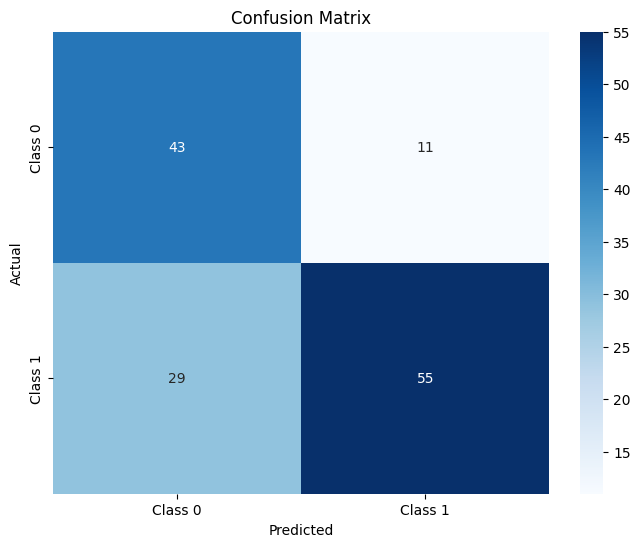

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.60      0.80      0.68        54
     Class 1       0.83      0.65      0.73        84

    accuracy                           0.71       138
   macro avg       0.72      0.73      0.71       138
weighted avg       0.74      0.71      0.71       138



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
print("Confusion Matrix:\n", cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Detailed classification report
report = classification_report(val_true_labels, val_predictions, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)
